# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [ ]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc.git

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (360/360), done.
remote: Total 404 (delta 228), reused 200 (delta 32), pack-reused 0
Receiving objects: 100% (404/404), 12.98 MiB | 38.08 MiB/s, done.
Resolving deltas: 100% (228/228), done.


In [ ]:
cd icpr2020dfdc/

/content/icpr2020dfdc


In [ ]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 4.9MB/s 
     |████████████████████████████████| 952kB 5.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=8905569f8ee8386b3d9308bb1e6006cdcda1ee71bb1876b928a06892e0569dc5
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
! pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=b22b5934154054274d445555416839aae6b715bce84fd2a34ad795b210847c95
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet, weights
from isplutils import utils

## Parameters

In [ ]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

## Initialization

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("blazeface/blazeface.pth")
facedet.load_anchors("blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

## Detect faces

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
vid_real_faces = face_extractor.process_video('/content/gdrive/My Drive/DeepFake Detection/dw_noeyes.mp4')
vid_fake_faces = face_extractor.process_video('/content/gdrive/My Drive/DeepFake Detection/putin_fake_noeyes.mp4')

#vid_real_faces = face_extractor.process_video('notebook/samples/lynaeydofd.mp4')
#vid_fake_faces = face_extractor.process_video('notebook/samples/mqzvfufzoq.mp4')

In [ ]:
im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]

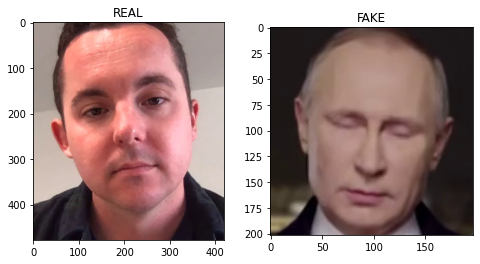

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores for each frame

In [ ]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


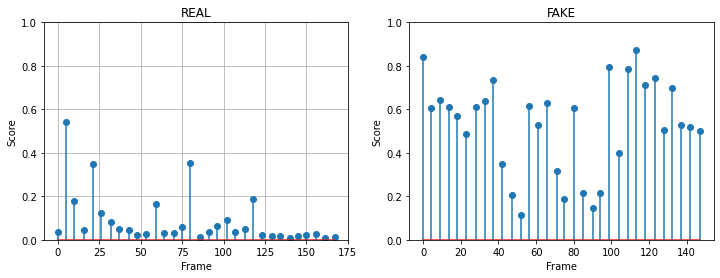

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.0483
Average score for FAKE face: 0.5274
